In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from datetime import date, datetime, timedelta


In [2]:
#Part I: Real Masurement Data
#Step 1: read semester files: 
def get_data():
    df0 = pd.read_csv("data/2015_S2.csv", sep = ";")
    df1 = pd.read_csv("data/2016_S1.csv", sep = ";")
    df2 = pd.read_csv("data/2016_S2.csv", sep = ";")
    df3 = pd.read_csv("data/2017_S1.csv", sep = ";")
    df4 = pd.read_csv("data/2017_S2.csv", sep = ";")
    df5 = pd.read_csv("data/2018_S1.csv", sep = ";")
    df6 = pd.read_csv("data/2018_S2.csv", sep = ";")
    df7 = pd.read_csv("data/2019_S1.csv", sep = ";")
    df8 = pd.read_csv("data/2019_S2.csv", sep = ";")
    df9 = pd.read_csv("data/2020_S1.csv", sep = ",")

    data0 = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9], ignore_index=True)
    print('read csv semester csv files from 2015s2 to 2020s1')
    return data0

df= get_data()

/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


read csv semester csv files from 2015s2 to 2020s1


In [3]:
# pd.read_csv("data/2019_S2.csv", sep = ";").head()
#check data types: 
df.dtypes

day           object
details       object
hour          object
precip       float64
radiation     object
scenario      object
speed        float64
temp          object
wind_dir      object
dtype: object

In [4]:
# Step 2: format data: change into numeric, reformate datetime 
def format_data(df):
    #set datetime
    df['datetime']= df['day']+' ' + df['hour']
    df['datetime'] = pd.to_datetime(df['datetime'], format= '%d/%m/%Y %Hh%M')
    df.drop(columns=['day','hour'], inplace=True)
    df.set_index('datetime', inplace=True)
    df.sort_index(inplace=True)
    df = df.dropna(axis=0, how='all')
    
    #convert dtypes to numeric: 
    c_list = ['wind_dir','speed','temp','radiation','precip']
    for c in c_list:
        df[c]= pd.to_numeric(df[c], errors= 'coerce')
    return df 

df = format_data(df)

/Users/cynthiazeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


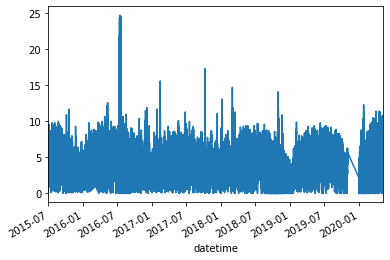

In [11]:
df['speed'].plot()

In [11]:
#Step 3: smooth wind direction into cos and sin:
def smooth_wind_dir(df):
    df['cos_wind_dir'] = np.cos(2 * np.pi * df['wind_dir'] / 360)
    df['sin_wind_dir'] = np.sin(2 * np.pi * df['wind_dir'] / 360)
    print('smooth wind direction')
    df.drop(columns=['wind_dir'], inplace=True)
    return df
# df= smooth_wind_dir(df)

In [12]:
#Step 4: calculate hourly data 
def daily_avg(df): #df has index datetime 
    
    # average wind_dir weighted by speed 
    temp = df[['cos_wind_dir','sin_wind_dir','speed']] 
    s1 = (temp['cos_wind_dir'] * temp['speed']).resample('H').sum() / (temp['speed'].resample('H')).sum()
    s2 = (temp['sin_wind_dir'] * temp['speed']).resample('H').sum() / (temp['speed'].resample('H')).sum()
    df1 = pd.concat([s1, s2], axis=1, keys=['cos_wind_dir','sin_wind_dir'])
    
    # arithmetic average for everything else:
    temp = df[['speed','temp','radiation','precip']]
    df2 = temp.resample('1H').mean()
    df_out = pd.concat([df1, df2], axis=1)
    return df_out 
df= daily_avg(df)

In [38]:
# Step 5: generate daily min and max for speed, temp, radiation 
def generate_daily(df): #df has index datetime 
    
    # 
    s1 = df['speed'].resample('D').min()
    s2 = df['speed'].resample('D').max()
    s3 = df['temp'].resample('D').min()
    s4 = df['temp'].resample('D').max()
    s5 = df['radiation'].resample('D').min()
    s6 = df['radiation'].resample('D').max()
    
    df_new = pd.concat([s1, s2, s3, s4, s5, s6], axis=1, keys=['d_speed_min', 'd_speed_max', 'd_temp_min' , 'd_temp_max','d_rad_min', 'd_rad_max'])
    df_out = pd.concat([df, df_new], axis=1)
    df_out = df_out.fillna(method='ffill')
    return df_out 

In [39]:
# Step 6: categorical features
def generate_season(df):
    df['season'] = 0
    df['month'] = df.index.month
    df.loc[df['month'].isin([12, 1, 2]), 'season'] = 1
    df.loc[df['month'].isin([3, 4, 5]), 'season'] = 2
    df.loc[df['month'].isin([6, 7, 8]), 'season'] = 3
    df.loc[df['month'].isin([9, 10, 11]), 'season'] = 4
    df.drop(['month'], axis=1, inplace=True)
    print('generate seasonality categorical feature')
    return df


def generate_day_night(df):
    s1=df.index.hour 
    df['day'] = 0
    df['night'] = 0
    df.loc[s1.isin([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]), 'day'] = 1
    df.loc[s1.isin([0, 1, 2, 3, 4, 5, 6, 7, 19, 20, 21, 22, 23]), 'night'] = 1
    print('generate day/night categorical feature')
    return df

In [41]:
#all together: 
def prepare_measurement_data():
    df = get_data()
    df = format_data(df)
    df= smooth_wind_dir(df)
    df= daily_avg(df)
    df = generate_daily(df)
    df = generate_season(df)
    df = generate_day_night(df)
    return df

In [59]:
#Part II: Forecast Data
#Step 1: get forecast data
def get_forecast():
    df = pd.read_csv('data/forecast_data_15_20.csv', sep = ";")
    df.columns= ['date','cycle','wind_dir','speed','temp','rad','precip']#rename cols 
    print('reading forecast data')
    return df

#Step 2: convert datetime format 
def format_forecast(df):
    #differentiate forecast period and resent period 
    df['f_date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M') #future_date
    df['p_date'] = pd.to_datetime(df['cycle'], format='%d/%m/%Y %Hh') #present_date
    df.drop(['date', 'cycle'], axis=1, inplace=True)
    #forecast period 
    df['f_period'] =df['f_date'] - df['p_date']
    df['f_period'] = df['f_period'].dt.components['hours']+df['f_period'].dt.components['days']*24
    return df


def keep_last_forecast (df0):
    df = df0.copy()
    df.sort_values(by=['f_date', 'p_date'], inplace=True)
    df.drop_duplicates(subset = "f_date", keep = 'last', inplace=True)
    print('keep last forecast, duplicates dropped = ', (df0.shape[0] - df.shape[0]))
    return df



In [61]:
def prepare_forecast(keep_last_forecast=False):
    df = get_forecast()
    df = format_forecast(df)
    df = smooth_wind_dir(df)
    if keep_last_forecast:
        df= keep_last_forecast(df)
    
    return df 
    

reading forecast data
smooth wind direction


In [22]:
#STEP 1: Read and Process Masurement Data
# Read 1 file per semester
def get_data():
    df0 = pd.read_csv("2015_S2.csv", sep = ";")
    df1 = pd.read_csv("2016_S1.csv", sep = ";")
    df2 = pd.read_csv("2016_S2.csv", sep = ";")
    df3 = pd.read_csv("2017_S1.csv", sep = ";")
    df4 = pd.read_csv("2017_S2.csv", sep = ";")
    df5 = pd.read_csv("2018_S1.csv", sep = ";")
    df6 = pd.read_csv("2018_S2.csv", sep = ";")
    df7 = pd.read_csv("2019_S1.csv", sep = ";")
    df8 = pd.read_csv("2019_S2.csv", sep = ";")

    data0 = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8], ignore_index=True)
    print('read csv semester csv files from 2015s2 to 2019s2')
    return data0


# Functions
# Convert scenario to one_hot
def scenario_one_hot(data, one_hot=False):
    # extract numeric data from scenario 'S1' to '1'
    data['scenario_num'] = (data['scenario'].str.extract('(\d+)')).astype(int)
    data.drop(['scenario'], axis=1, inplace=True)

    # add one-hot encoding to scenario:
    if one_hot:
        scenario = pd.get_dummies(data['scenario_num'], prefix='scenario', dummy_na=True)
        data1 = pd.concat([data, scenario], axis=1)
        return data1
    return data


# Make cyclical data into continuous data using cos & sin
def smooth_wind_dir(data):
    data['cos_wind_dir'] = np.cos(2 * np.pi * data['wind_dir'] / 360)
    data['sin_wind_dir'] = np.sin(2 * np.pi * data['wind_dir'] / 360)
    print('smooth wind direction')
    return data


def smooth_hour(data):
    # split '00h00' to two columns of numeric values
    hour = data['hour'].str.split(pat='h', expand=True)
    hour = hour.apply(pd.to_numeric, errors='coerce')

    # calculate minutes passed since 00h00
    hour['minutes'] = 60 * hour[0] + hour[1]
    hour['cos_hour'] = np.cos(2 * np.pi * hour['minutes'] / (60 * 24))
    hour['sin_hour'] = np.sin(2 * np.pi * hour['minutes'] / (60 * 24))

    # concat and update dataframe
    data = pd.concat([data, hour[['cos_hour', 'sin_hour']]], axis=1)
    print('smooth hour')
    return data


# Smooth date
def smooth_day(data):
    # Convert day & hour to date-time format
    data['datetime'] = data['day'].str.cat(data['hour'], sep=' ')
    data['datetime'] = pd.to_datetime(data['datetime'], format='%d/%m/%Y %Hh%M')
    data['day'] = pd.to_datetime(data['day'], format='%d/%m/%Y')
    data['hour'] = data['hour'].str.extract('(\d+)')
    data['hour'] = pd.to_numeric(data['hour'])

    # Calculate time delta since 1st entry
    data['day_delta'] = pd.to_numeric(data['day'] - data['day'][0])
    data['cos_day'] = np.cos(2 * np.pi * data['day_delta'] / (365))
    data['sin_day'] = np.sin(2 * np.pi * data['day_delta'] / (365))
    data.drop(['day_delta', 'day'], axis=1, inplace=True)

    print('smooth day')
    return data


# Generate new features:
# Generate daily features: daily min, max
def generate_daily(df):
    # group data into daily batches
    grouped = df.resample('D')
    min_speed = []
    max_speed = []
    min_hour = []
    max_hour = []

    for datetime, group in grouped:
        # find daily min & max
        s1 = group['speed'].min()
        s2 = group['speed'].max()
        # find the time of min & max speed
        h1 = group.loc[group['speed'] == s1]['hour'].values[0]
        h2 = group.loc[group['speed'] == s2]['hour'].values[0]

        min_speed.append(s1)
        max_speed.append(s2)
        min_hour.append(h1)
        max_hour.append(h2)

    # output new features as a dataframe
    start = df.index[0].date()
    end = df.index[-1].date()
    date_range = pd.date_range(start, end, freq='D')
    daily = pd.concat([pd.Series(min_speed), pd.Series(min_hour), pd.Series(max_speed), pd.Series(max_hour)], axis=1,
                      keys=['daily_min_speed', 'daily_min_hour', 'daily_max_speed', 'daily_max_hour'])
    daily.set_index(date_range, inplace=True)

    # #merge new features into dataframe: match with date
    df_out = pd.merge(df, daily, how='outer', left_index=True, right_index=True)
    # fill NaN values with same daily values
    df_out = df_out.fillna(method='ffill')

    print('generate daily features: %s' % (daily.columns.to_list()))
    return df_out


# Categorical features
def generate_season(df):
    df['season'] = 0
    df['month'] = df.index.month
    df.loc[df['month'].isin([12, 1, 2]), 'season'] = 1
    df.loc[df['month'].isin([3, 4, 5]), 'season'] = 2
    df.loc[df['month'].isin([6, 7, 8]), 'season'] = 3
    df.loc[df['month'].isin([9, 10, 11]), 'season'] = 4
    df.drop(['month'], axis=1, inplace=True)
    print('generate seasonality categorical feature')
    return df


def generate_day_night(df):
    df['day'] = 0
    df['night'] = 0
    df.loc[df['hour'].isin([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]), 'day'] = 1
    df.loc[df['hour'].isin([0, 1, 2, 3, 4, 5, 6, 7, 19, 20, 21, 22, 23]), 'night'] = 1
    print('generate day/night categorical feature')
    return df


# Function to prepare data using above functions
def prepare_data(one_hot=False):
    # Interpolate missing values
    data0 = get_data()
    data = data0.interpolate()
    data = data.fillna(method='ffill')

    # scenario to one-hot encoding
    data = scenario_one_hot(data, one_hot)

    # smooth wind_dir, hour, and day using cos & sin function
    data = smooth_wind_dir(data)
    data = smooth_hour(data)
    data = smooth_day(data)
    try:
        data.drop(['details'], axis=1, inplace=True)
    except:
        print("No details column")
    data.index = data['datetime']
    data = data.interpolate()

    # averaging 15min data to hourly
    data = data.resample('H').mean()
    data = data.round({'scenario_num': 0})

    # generate daily max & min wind speed features
    data = generate_daily(data)

    # generate seasonal, day/night categorical features
    data = generate_season(data)
    data = generate_day_night(data)

    return data


#STEP 2: Merging with Forecast Data
#get forecast data
def get_forecast():
    df= pd.read_csv('weather_forecast_data_for_cynthia.csv', sep = ";")
    print('reading forecast data')
    return df

#convert to datetime index
def convert_datetime(df):
    df['f_date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M') #future_date
    df['cycle']=df['cycle'].str.replace('h', ':00', regex=True)
    df['p_date'] = pd.to_datetime(df['cycle'], format='%d/%m/%Y %H:%M') #present_date
    df.drop(['date', 'cycle'], axis=1, inplace=True)
    return df

#calculate forecast period in hours
def forecast_period(df):
    df['f_period'] =df['f_date'] - df['p_date']
    df['f_period'] = df['f_period'].dt.components['hours']+df['f_period'].dt.components['days']*24
    return df


def keep_last_forecast (df0):
    df= df0.copy()
    df.sort_values(by=['f_date', 'p_date'], inplace=True)
    df.drop_duplicates(subset = "f_date", keep = 'last', inplace=True)
    print('keep last forecast, duplicates dropped = ', (df0.shape[0] - df.shape[0]))
    return df


#rename columns
def rename_cols(df):
    df = df.rename(columns={"Wind direction": "wind_dir", "Wind speed (m/s)": "speed"}) # additional features"temperature (ｰC)": "temp", "rayonnement (W/m2)": "radiation","precip (mm/h)":"precip"
    #keep just wind_dir and speed features
    df = df[['wind_dir','speed','f_date','p_date','f_period']]
    #index with future date
    df.set_index('f_date', inplace=True)
    return df


#merge data with forecast data
def prepare_data_with_forecast(data, keep_only_last = True):
    #get prepared measurement data
    data_merge = data.copy()
    forecast = get_forecast()
    df= convert_datetime(forecast)
    df = forecast_period(df)
    if keep_only_last:
        df = keep_last_forecast (df)
    df= rename_cols(df)
    df = smooth_wind_dir(df)
    data_merge = data_merge.join(df, how='left', rsuffix='_forecast')
    forecast = df.copy()
    print('merge with forecast data')
    return data_merge, data, forecast


# data=prepare_data(one_hot=False)
# data_merge, data, forecast  = prepare_data_with_forecast(data)




In [ ]:
#check data types: 
df.dtypes